# Figures

In [1]:
import glob

import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

from natsort import natsorted
from matplotlib import rcParams
from scipy.stats import pearsonr

scv.settings.figdir = '../results/'

In [2]:
def get_sc_batch(folder: str, obs_xlsx: str) -> sc.AnnData:
    
    files = natsorted(glob.glob(f"{folder}/*.txt"))
    sb = pd.concat([pd.read_table(f) for f in files], axis=1).T
    sb = sc.AnnData(X=sb.values, obs=pd.read_excel(obs_xlsx, index_col=0))
    
    sc.pp.calculate_qc_metrics(sb, inplace=True)
    
    return sb

In [3]:
vanilla_sb26 = get_sc_batch(folder='../data/raw/MARSseq2.0/SB26/output/umi.tab/', 
    obs_xlsx="/home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB26/wells_cells.xlsx")
vanilla_sb28 = get_sc_batch(folder='../data/raw/MARSseq2.0/SB28/output/umi.tab/', 
    obs_xlsx="/home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB28/wells_cells.xlsx")

mars_sb26 = get_sc_batch(folder='../data/raw/marsseq/SB26/results/SB26/output/umi.tab/', 
    obs_xlsx="/home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB26/wells_cells.xlsx")
mars_sb28 = get_sc_batch(folder='../data/raw/marsseq/SB28/results/SB28/output/umi.tab/', 
    obs_xlsx="/home/fdb589/projects/people/fdb589/projects/proks_et_al_2022/pipeline/SB28/wells_cells.xlsx")

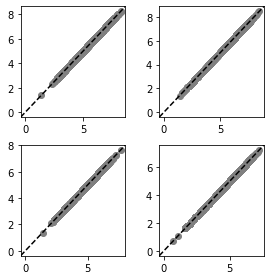

In [4]:
fig, ax = plt.subplots(2,2, figsize=[4, 4])

ax[0, 0].scatter(vanilla_sb26.obs.log1p_total_counts, mars_sb26.obs.log1p_total_counts, c='grey')
# ax[0, 0].set_title('SB26')
# ax[0, 0].set_xlabel('MARSseq2.0 log(counts)')
# ax[0, 0].set_ylabel('marsseq log(counts)')
ax[0, 0].axline((0, 0), slope=1, color='black', linestyle='--')

ax[0, 1].scatter(vanilla_sb28.obs.log1p_total_counts, mars_sb28.obs.log1p_total_counts, c='grey')
# ax[0, 1].set_title('SB28')
# ax[0, 1].set_xlabel('MARSseq2.0 log(counts)')
# ax[0, 1].set_ylabel('marsseq log(counts)')
ax[0, 1].axline((0, 0), slope=1, color='black', linestyle='--')

ax[1, 0].scatter(vanilla_sb26.obs.log1p_n_genes_by_counts, mars_sb26.obs.log1p_n_genes_by_counts, c='grey')
# ax[1, 0].set_title('SB26')
# ax[1, 0].set_xlabel('MARSseq2.0 log(genes)')
# ax[1, 0].set_ylabel('marsseq log(genes)')
ax[1, 0].axline((0, 0), slope=1, color='black', linestyle='--')

ax[1, 1].scatter(vanilla_sb28.obs.log1p_n_genes_by_counts, mars_sb28.obs.log1p_n_genes_by_counts, c='grey')
# ax[1, 1].set_title('SB28')
# ax[1, 1].set_xlabel('MARSseq2.0 log(genes)')
# ax[1, 1].set_ylabel('marsseq log(genes)')
ax[1, 1].axline((0, 0), slope=1, color='black', linestyle='--')
plt.tight_layout()

fig.savefig("../results/metrics.svg")

## in vivo

In [5]:
random_seed = 12345


def run_scvelo(adata):
    import scvelo as scv
    """Run basic workflow for computing velocities."""
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    sc.tl.pca(adata, random_state=random_seed)
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=random_seed)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.recover_dynamics(adata, n_jobs=8)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata)
    
    return adata

In [6]:
vivo = sc.read("../data/external/05_scvelo_ver_2.h5ad")

In [7]:
subset = vivo[vivo.obs.cluster_names.isin([
    'Hindgut1',
    'Hindgut2',
    'Midgut',
    'Foregut',
    'DE1',
    'DE2',
    'PS1',
    'PS2',
    'InterVE',
    'ExVE1',
    'ExVE2',
    'EmVE',
    'AVE',
    'Notochord',
    'Node'
])].copy()

subset.obs.cluster_names = subset.obs.cluster_names.astype('category')

In [8]:
subset = run_scvelo(subset)

Filtered out 26924 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/224 cores)


  0%|          | 0/943 [00:00<?, ?gene/s]

    finished (0:02:58) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/224 cores)


  0%|          | 0/4868 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../results/scvelo_invivo.svg


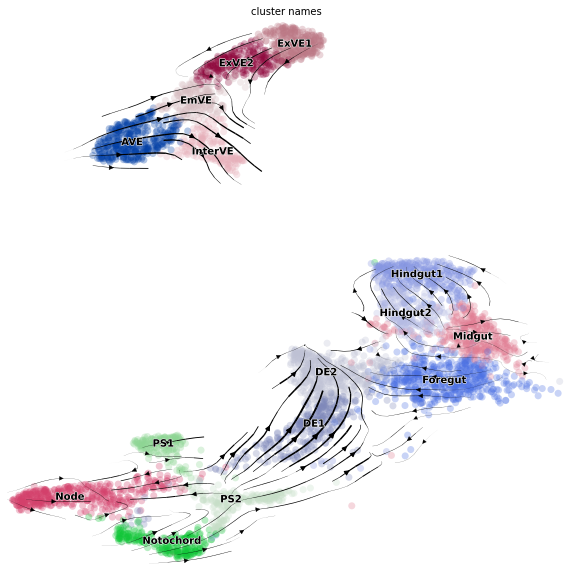

saving figure to file ../results/scvelo_invivo-arrows.svg


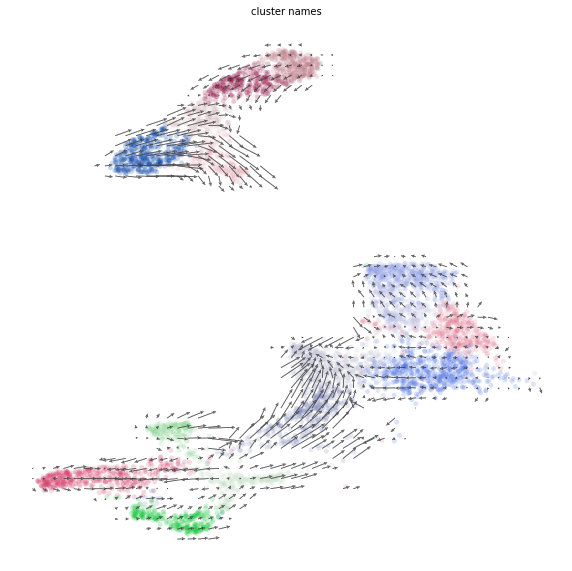

In [9]:
rcParams['figure.figsize'] = [10, 10]
scv.pl.velocity_embedding_stream(subset, basis='umap', color='cluster_names', save='invivo.svg')
scv.pl.velocity_embedding_grid(subset, basis='umap', color='cluster_names', arrow_length=3, save='invivo-arrows.svg')

In [61]:
subset.uns['cluster_names_colors']

['#023fa5',
 '#7d87b9',
 '#bec1d4',
 '#d6bcc0',
 '#bb7784',
 '#8e063b',
 '#4a6fe3',
 '#8595e1',
 '#b5bbe3',
 '#e6afb9',
 '#e07b91',
 '#d33f6a',
 '#11c638',
 '#8dd593',
 '#c6dec7']

## in vitro

In [10]:
vitro = sc.read("../data/processed/02_dataset.h5ad")

In [11]:
sc.tl.diffmap(vitro, random_state=random_seed)
sc.tl.draw_graph(vitro, random_state=random_seed)

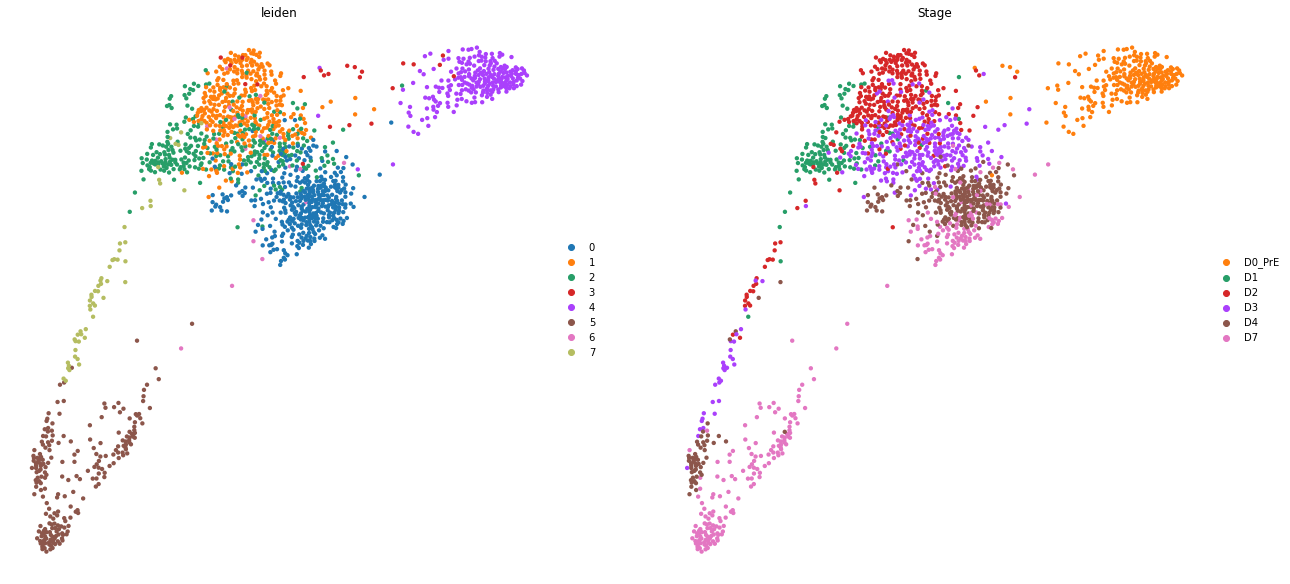

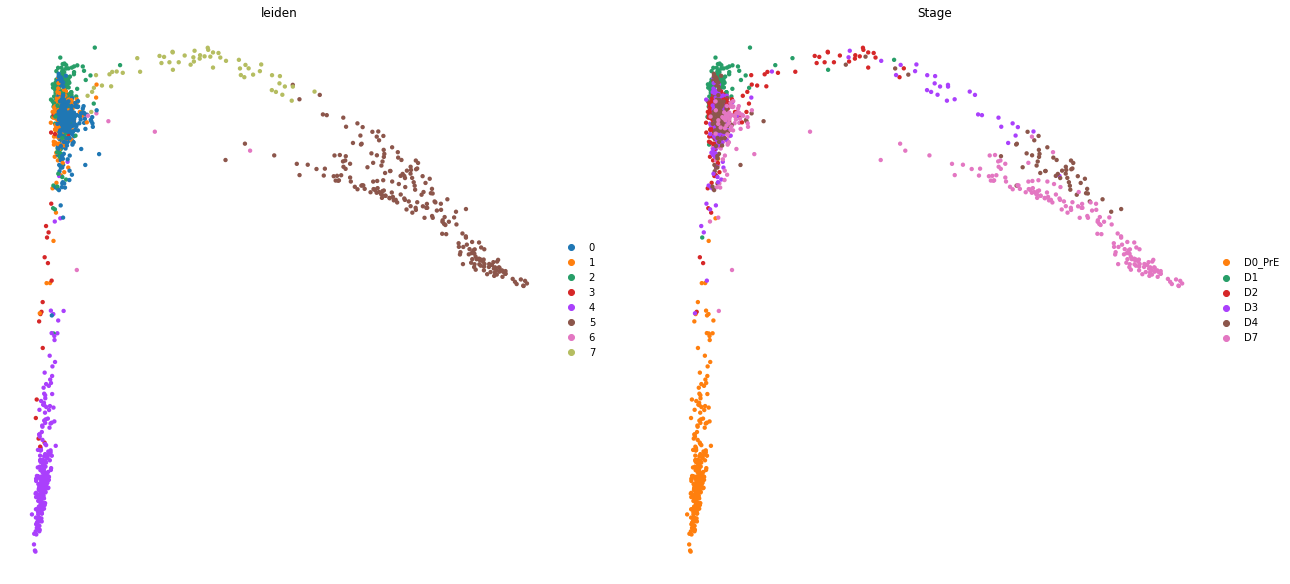

In [12]:
sc.pl.draw_graph(vitro, layout='fa', color=['leiden', 'Stage'], frameon=False)
sc.pl.diffmap(vitro, color=['leiden', 'Stage'], frameon=False)

saving figure to file ../results/scvelo_vitro.svg


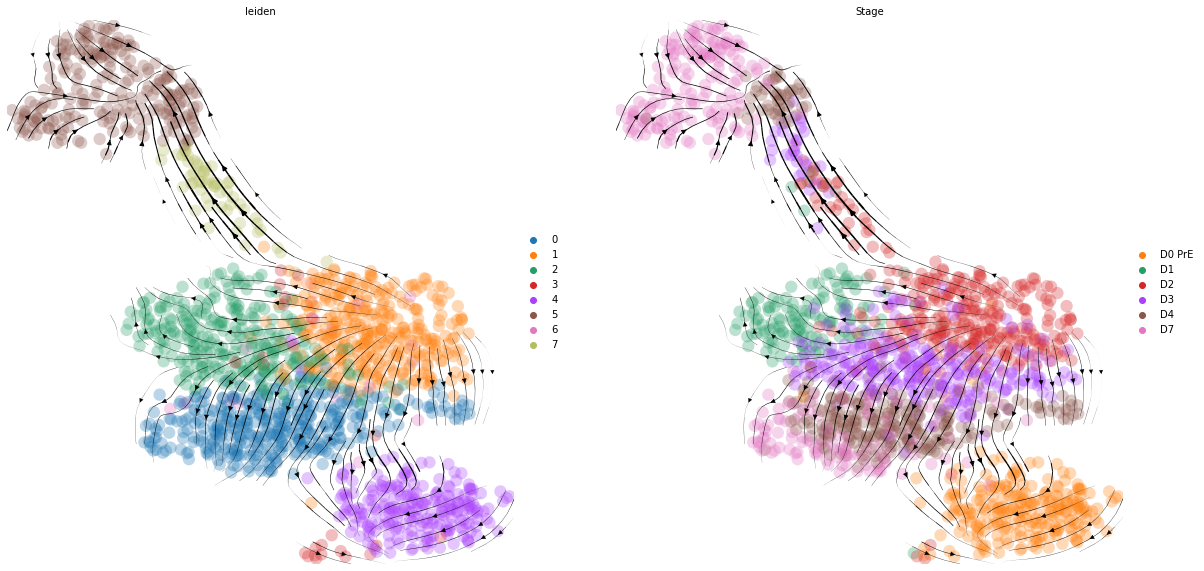

In [13]:
scv.pl.velocity_embedding_stream(vitro, basis='umap', color=['leiden', 'Stage'], legend_loc='right', save='vitro.svg')
# scv.pl.velocity_embedding_stream(vitro, basis='diffmap', color=['leiden', 'Stage'])
# scv.pl.velocity_embedding_stream(vitro, basis='draw_graph_fa', color=['leiden', 'Stage'])

In [68]:
vitro.uns['Stage_colors']

array(['#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2'],
      dtype=object)

In [100]:
color_pallete =  ["#a0126d", "#1aa6de", "#28ba70", "#e23024", "#ed7d31", "#cddb9b", "#1d686e", "#a0a3fd", "#724073", "#f669cc", "#763bcb", "#3163d8", "#99ea40", "#687f39", "#cace01"]
subset.uns['cluster_names_colors'] = color_pallete
# vitro.uns['Stage_colors'] = color_pallete[:6][::-1]
vitro.uns['Stage_colors'] = ["#cace01", "#19A6DE", "#A1166D", "#28B96F", "#E33126", "#ED7D31"]

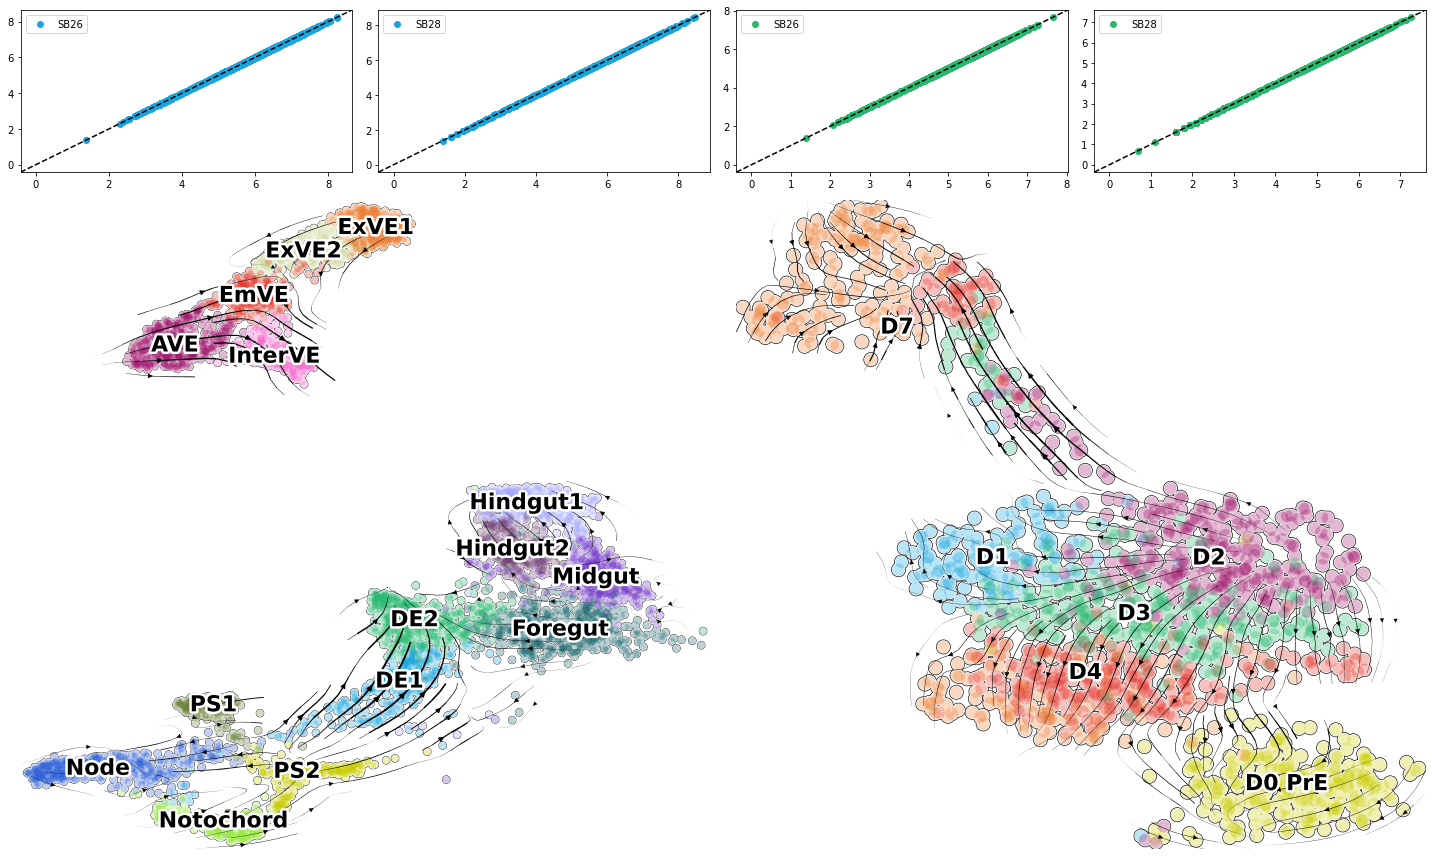

In [171]:
fig = plt.figure(figsize=(20, 12))
spec = fig.add_gridspec(ncols=4, nrows=2, height_ratios=[1,4])

ax00 = fig.add_subplot(spec[0, 0])
ax00.scatter(vanilla_sb26.obs.log1p_total_counts, mars_sb26.obs.log1p_total_counts, c='#19A6DE', label='SB26')
# ax00.set_title('SB26')
# ax00.set_xlabel('MARSseq2.0')
# ax00.set_ylabel('nf-core/marsseq')
ax00.axline((0, 0), slope=1, color='black', linestyle='--')
ax00.legend()
# ax00.text(-1.5, 8, 'A', fontsize = 30)

ax01 = fig.add_subplot(spec[0, 1])
ax01.scatter(vanilla_sb28.obs.log1p_total_counts, mars_sb28.obs.log1p_total_counts, c='#19A6DE', label='SB28')
# ax01.set_title('SB28')
# ax01.set_xlabel('MARSseq2.0 log(counts)')
# ax01.set_ylabel('marsseq log(counts)')
ax01.axline((0, 0), slope=1, color='black', linestyle='--')
ax01.legend()

ax02 = fig.add_subplot(spec[0, 2])
ax02.scatter(vanilla_sb26.obs.log1p_n_genes_by_counts, mars_sb26.obs.log1p_n_genes_by_counts, c='#28B96F', label='SB26')
# ax02.set_title('SB26')
# ax02.set_xlabel('MARSseq2.0 log(genes)')
# ax02.set_ylabel('marsseq log(genes)')
ax02.axline((0, 0), slope=1, color='black', linestyle='--')
ax02.legend()

ax03 = fig.add_subplot(spec[0, 3])
ax03.scatter(vanilla_sb28.obs.log1p_n_genes_by_counts, mars_sb28.obs.log1p_n_genes_by_counts, c='#28B96F', label='SB28')
# ax03.set_title('SB28')
# ax03.set_xlabel('MARSseq2.0 log(genes)')
# ax03.set_ylabel('marsseq log(genes)')
ax03.axline((0, 0), slope=1, color='black', linestyle='--')
ax03.legend()

ax11 = fig.add_subplot(spec[1, :2])
scv.pl.velocity_embedding_stream(subset, basis='umap', color='cluster_names', show=False, title='', 
                                 legend_loc='on data', legend_fontsize=22, legend_fontoutline=5, add_outline=True, outline_width=(0.05, 0.05), ax=ax11)
# ax11.text(-6.95, 15, 'B', fontsize = 30)

ax12 = fig.add_subplot(spec[1, 2:])
scv.pl.velocity_embedding_stream(vitro, basis='umap', color='Stage', show=False, title='', 
                                 legend_loc='on data', legend_fontsize=22, legend_fontoutline=5, add_outline=True, outline_width=(0.05, 0.05), ax=ax12)
# ax12.text(6, 14.6, 'C', fontsize = 30)

plt.tight_layout()
fig.savefig('../results/fig3.svg')

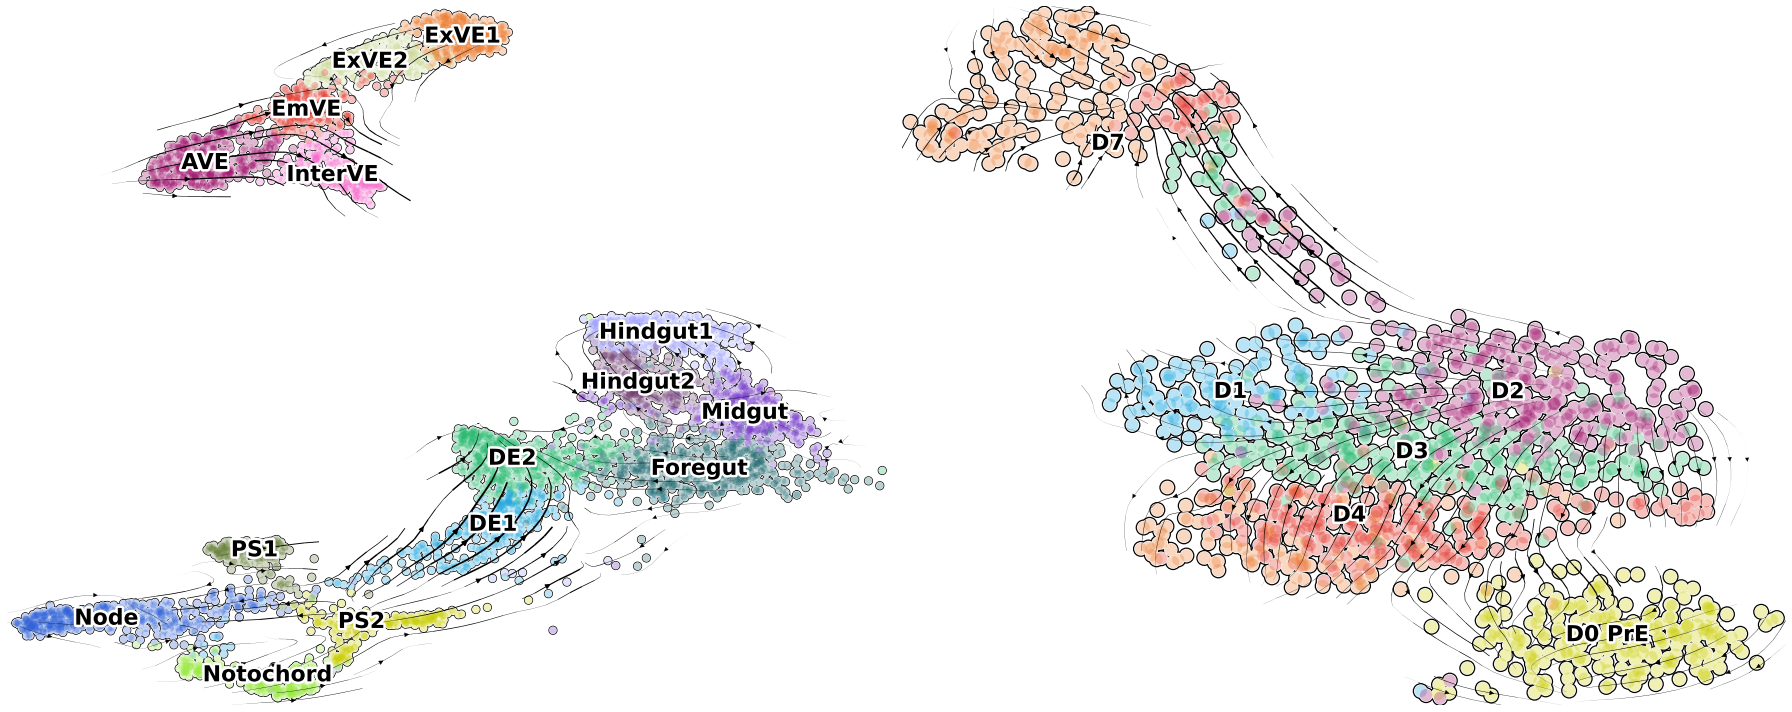

In [165]:
# fig, ax = plt.subplots(1, 4, figsize=[25, 4])
# ax[0].scatter(vanilla_sb26.obs.log1p_total_counts, mars_sb26.obs.log1p_total_counts, c='#19A6DE', label='SB26')
# ax[0].axline((0, 0), slope=1, color='black', linestyle='--')
# ax[0].legend(prop={'size': 17}, handletextpad=0.1)

# ax[1].scatter(vanilla_sb28.obs.log1p_total_counts, mars_sb28.obs.log1p_total_counts, c='#19A6DE', label='SB28')
# ax[1].axline((0, 0), slope=1, color='black', linestyle='--')
# ax[1].legend(prop={'size': 17}, handletextpad=0.1)

# ax[2].scatter(vanilla_sb26.obs.log1p_n_genes_by_counts, mars_sb26.obs.log1p_n_genes_by_counts, c='#28B96F', label='SB26')
# ax[2].axline((0, 0), slope=1, color='black', linestyle='--')
# ax[2].legend(prop={'size': 17}, handletextpad=0.1)

# ax[3].scatter(vanilla_sb28.obs.log1p_n_genes_by_counts, mars_sb28.obs.log1p_n_genes_by_counts, c='#28B96F', label='SB28')
# ax[3].axline((0, 0), slope=1, color='black', linestyle='--')
# ax[3].legend(prop={'size': 17}, handletextpad=0.1)
# plt.tight_layout()
# plt.show()
# fig.savefig('../results/fig3-1.svg')

fig, ax = plt.subplots(1, 2, figsize=[25, 10])
scv.pl.velocity_embedding_stream(
    subset, basis='umap', color='cluster_names', show=False, title='', legend_loc='on data', legend_fontsize=22, legend_fontoutline=5, add_outline=True, outline_width=(0.1, 0.05), ax=ax[0])
scv.pl.velocity_embedding_stream(
    vitro, basis='umap', color='Stage', show=False, title='', legend_loc='on data', legend_fontsize=22, legend_fontoutline=5, add_outline=True, outline_width=(0.1, 0.05), ax=ax[1])
plt.tight_layout()
plt.show()
fig.savefig('../results/fig3-2.svg')